In [113]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.impute import SimpleImputer


pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", None)

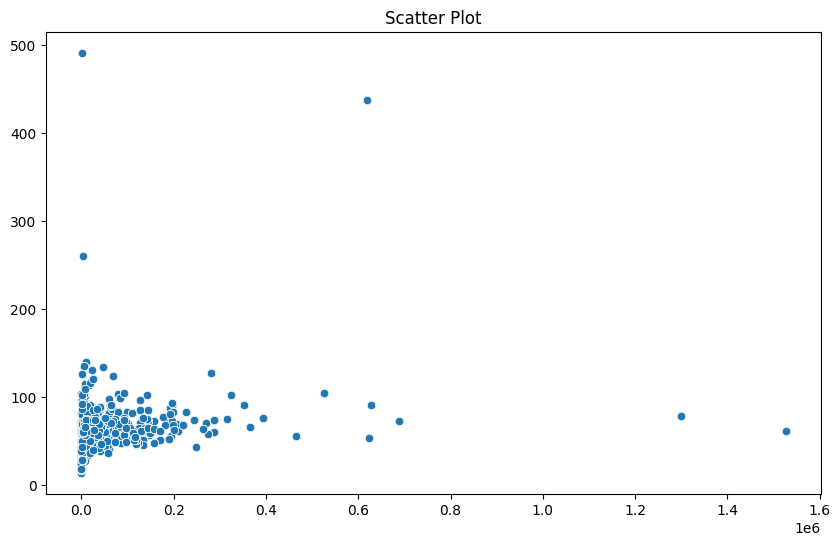

      mean_gdp  emp_total_county_naics  emp_total_county_naics_top5_occ        ap       est  emp_occupation        as   as_top5  FIPS  naics  OCC_CODE
0    -0.397398               -0.392728                        -0.298163 -0.372035 -0.405236       -0.251651 -0.399072 -0.295734     0      0         0
1    -0.397398               -0.392728                        -0.298163 -0.372035 -0.405236       -0.249861 -0.399072 -0.295734     0      0         4
2    -0.378683               -0.377858                        -0.295818 -0.366409 -0.333979       -0.250179 -0.943698 -0.294790     1      0         0
3    -0.378683               -0.377858                        -0.295818 -0.366409 -0.333979       -0.251684 -0.943698 -0.294790     1      0         2
4    -0.378683               -0.377858                        -0.295818 -0.366409 -0.333979       -0.251727 -0.943698 -0.294790     1      0         3
...        ...                     ...                              ...       ...       ...   

In [114]:
with open("../data/processed/masterFrame.pkl", "rb") as file:
    master_df = pickle.load(file)

master_df = master_df.drop(columns=["ap_nf"])

# Handle missing values
imputer = SimpleImputer(strategy="mean")
master_df_clean = pd.DataFrame(
    imputer.fit_transform(
        master_df.drop(columns=["FIPS", "naics", "OCC_CODE"])),
        columns=master_df.columns.drop(["FIPS", "naics", "OCC_CODE"])
)

master_df_clean.dropna(inplace=True)
master_df_clean["FIPS"] = master_df["FIPS"].astype(str)
master_df_clean["naics"] = master_df["naics"].astype(str)
master_df_clean["OCC_CODE"] = master_df["OCC_CODE"].astype(str)

le = LabelEncoder()
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=master_df_clean,
    x=master_df["ap"],
    y=master_df["as"],
)
plt.title('Scatter Plot')
plt.xlabel('');
plt.ylabel('');
plt.show()

numerical_columns = master_df_clean.select_dtypes(include=["float64", "int64"]).columns


all_features = [
    "FIPS",
    "naics",
    "OCC_CODE",
    "mean_gdp",
    "emp_total_county_naics",
    "emp_total_county_naics_top5_occ",
    "ap",
    "est",
    "emp_occupation",
    "as",
    "as_top5",
]

master_df_clean[numerical_columns] = min_max_scaler.fit_transform(master_df_clean[numerical_columns])
master_df_clean[numerical_columns] = standard_scaler.fit_transform(master_df_clean[numerical_columns])

master_df_clean["FIPS"] = le.fit_transform(master_df["FIPS"])
master_df_clean["naics"] = le.fit_transform(master_df["naics"])
master_df_clean["OCC_CODE"] = le.fit_transform(master_df["OCC_CODE"])

print(master_df_clean)

# TODO: Elbow into clustering
# TODO: EMP normal, as normal vs emp top2 & as top5 clustering (ohne occ nur fips/naics)

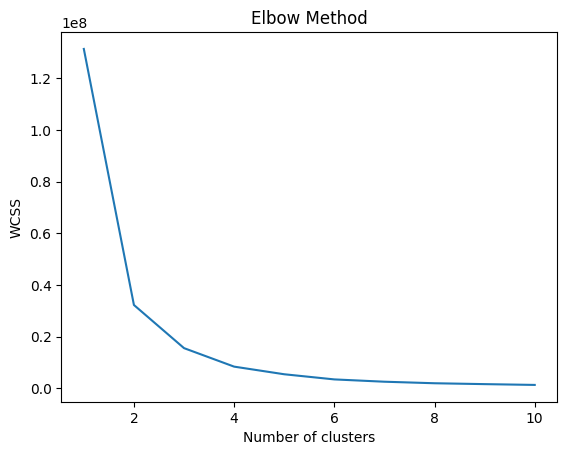

In [115]:
# Use Elbow Method to determine the optimal number of clusters
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(
        n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=0
    )
    kmeans.fit(master_df_clean[all_features])
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

# From the plot we assume that the optimal number of clusters are 3

In [116]:
# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=3, init="k-means++", max_iter=300, n_init=10, random_state=0)
master_df_clean["Cluster"] = kmeans.fit_predict(master_df_clean[all_features])

In [117]:
# View the clustered data
print(master_df_clean)

# Select numeric columns for the summary
numeric_cols = master_df_clean.select_dtypes(include=["number"]).columns

# Summary of clusters
cluster_summary = master_df_clean.groupby("Cluster")[numeric_cols].mean()
print(cluster_summary)

      mean_gdp  emp_total_county_naics  emp_total_county_naics_top5_occ        ap       est  emp_occupation        as   as_top5  FIPS  naics  OCC_CODE  Cluster
0    -0.397398               -0.392728                        -0.298163 -0.372035 -0.405236       -0.251651 -0.399072 -0.295734     0      0         0        1
1    -0.397398               -0.392728                        -0.298163 -0.372035 -0.405236       -0.249861 -0.399072 -0.295734     0      0         4        1
2    -0.378683               -0.377858                        -0.295818 -0.366409 -0.333979       -0.250179 -0.943698 -0.294790     1      0         0        1
3    -0.378683               -0.377858                        -0.295818 -0.366409 -0.333979       -0.251684 -0.943698 -0.294790     1      0         2        1
4    -0.378683               -0.377858                        -0.295818 -0.366409 -0.333979       -0.251727 -0.943698 -0.294790     1      0         3        1
...        ...                     ...  

In [118]:
# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(master_df_clean[all_features])

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

# Add the cluster assignments to the PCA DataFrame
pca_df["Cluster"] = master_df_clean["Cluster"]

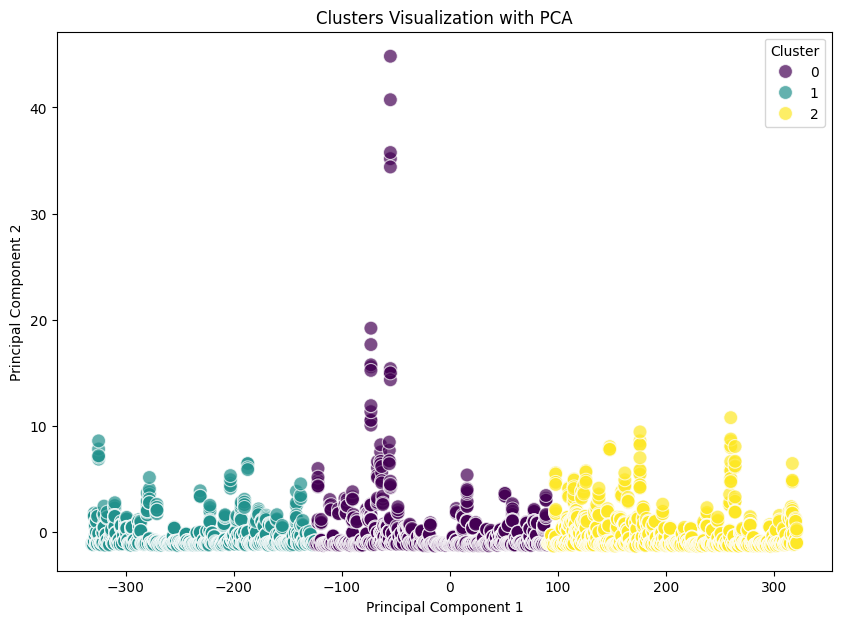

In [119]:
# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1", y="PC2", hue="Cluster", data=pca_df, palette="viridis", s=100, alpha=0.7
)
plt.title("Clusters Visualization with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()